No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


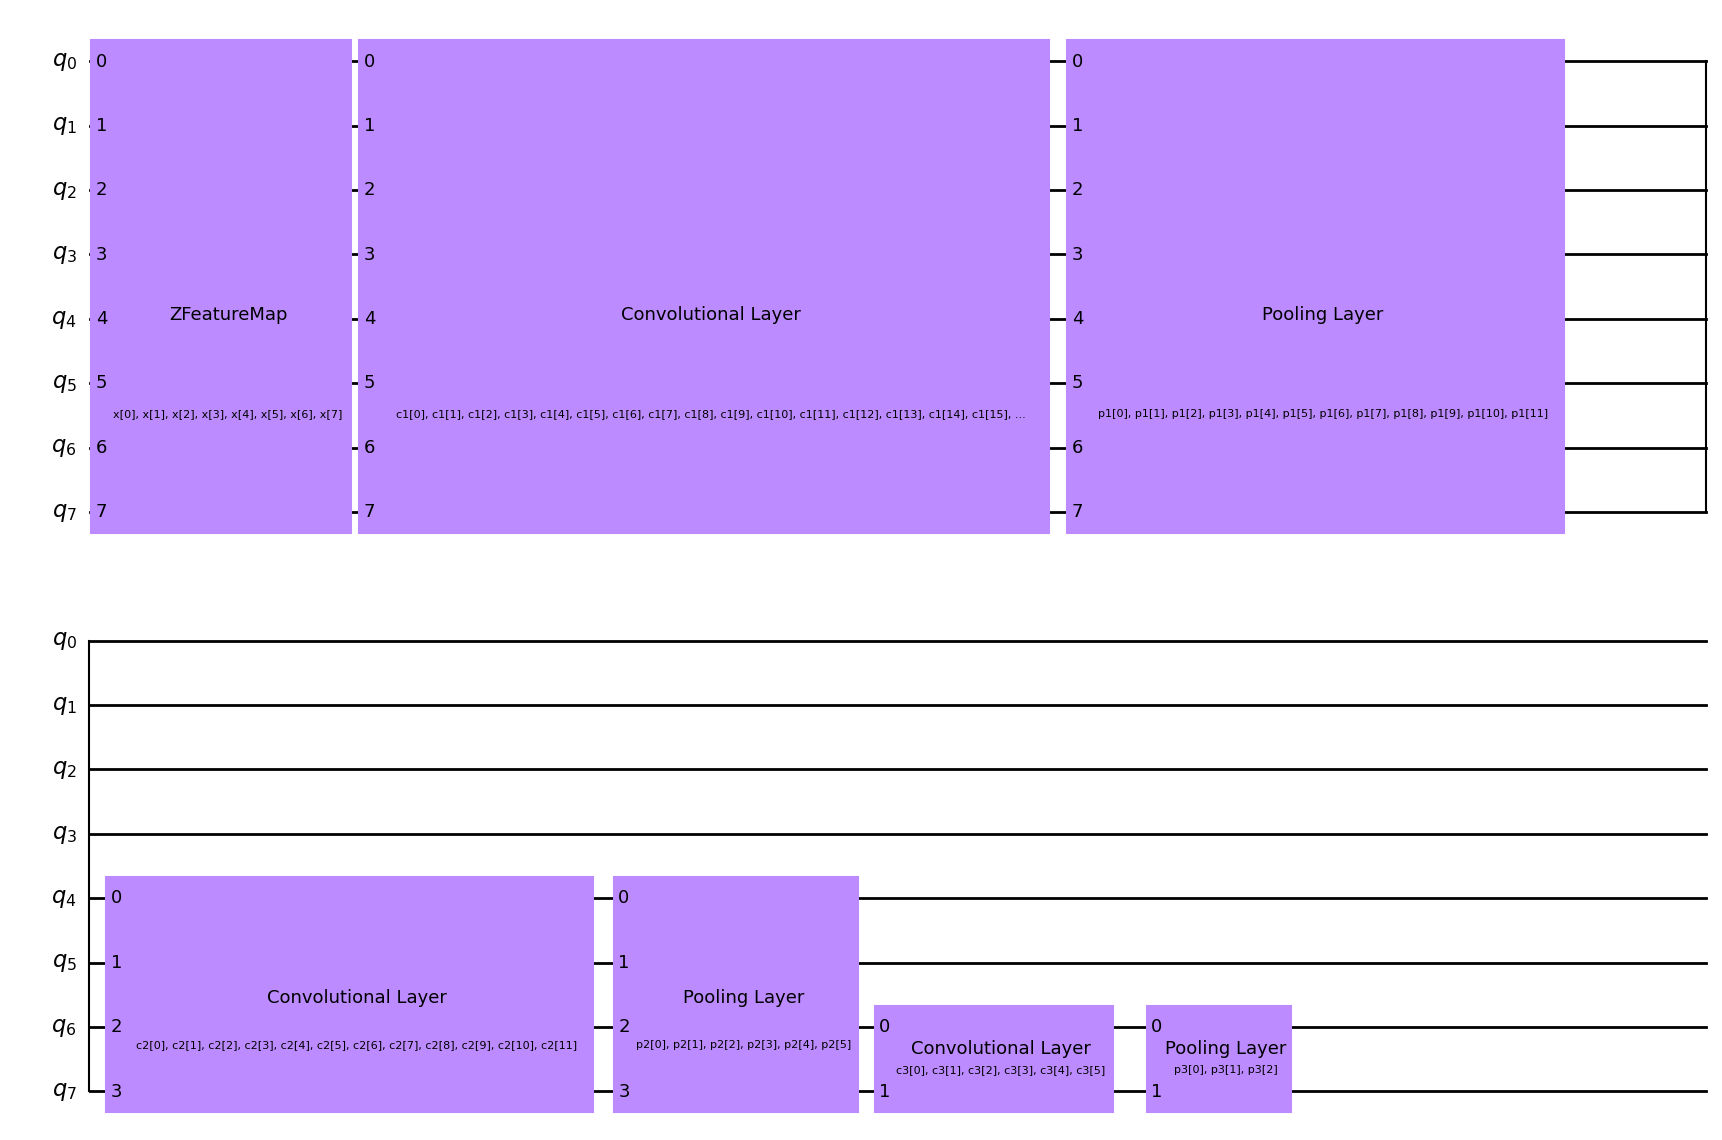

In [19]:
from qcnn.model import qcnn
from qcnn.datasets import generate_line_dataset
import matplotlib.pyplot as plt
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

width, height = 4, 2
circuit, qnn = qcnn(width * height)
circuit.draw("mpl", style="clifford")

In [21]:
images, labels = generate_line_dataset(50, width=width, height=height, min_l=2, max_l=2)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

In [23]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [45]:
w = np.load("qcnn_weights.npy")
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),  # Set max iterations here
    callback=callback_graph,
    #initial_point=w
)

In [ ]:
saved_names = list(np.load("qcnn_param_names.npy", allow_pickle=True))
saved_w = np.load("qcnn_weights.npy")
name2val = dict(zip(saved_names, saved_w))

# rebuild qnn identically, then reorder to current param order:
w_aligned = np.array([name2val[p.name] for p in qnn.weight_params], dtype=float)

classifier = NeuralNetworkClassifier(
    qnn, optimizer=COBYLA(maxiter=200), initial_point=w_aligned
)

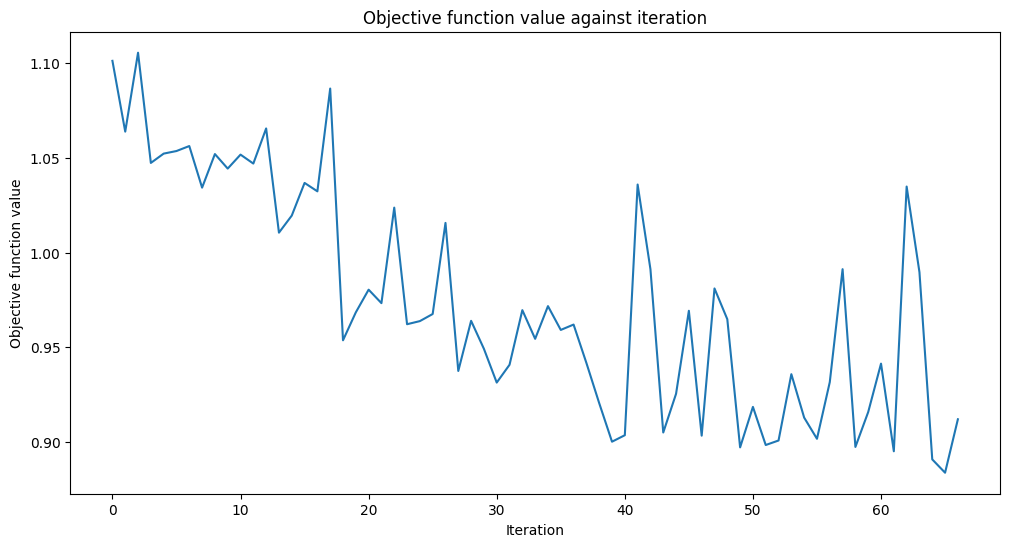

In [ ]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [40]:
param_names = [p.name for p in qnn.weight_params]
np.save("qcnn_param_names.npy", np.array(param_names, dtype=object))
np.save("qcnn_weights.npy", classifier.weights)

Accuracy from the test data : 80.0%


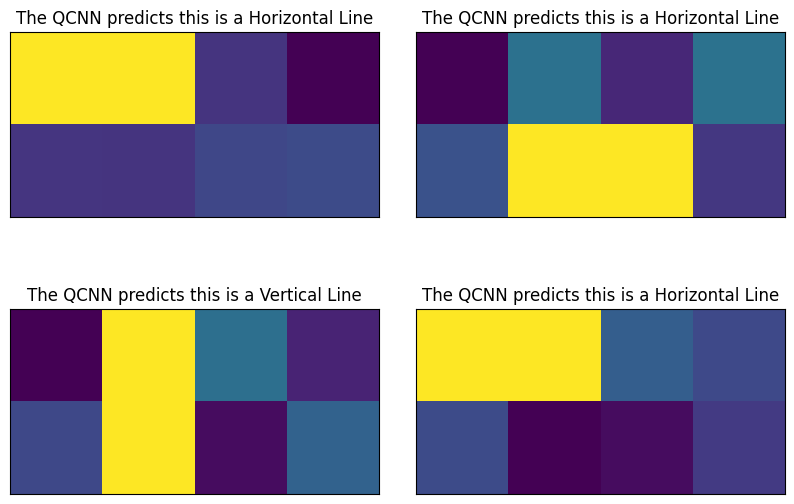

In [32]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(height, width), aspect="equal") # 1D length = pixels -> height x width image
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

